# Imports

In [1]:
#Easy data manipulation
import pandas as pd
import numpy as np

#Plotting
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

#Who likes warnings anyway?
import warnings
warnings.filterwarnings('ignore')

#Automated hyperparameter tuning
from tpot import TPOTClassifier

#Fill missing values
from sklearn.impute import SimpleImputer

#Pre-processing, tuning of parameters and scoring tools
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler

#Text Mining
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import text #Allow stop_words customization

#ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Not sure if required to import for sklearn models n_jobs=-1 and for Tpot approach
import joblib
import xgboost

#Used to keep track of progress during long operations
from IPython.display import clear_output

# First look at the data set

In [2]:
df = pd.read_csv('winemag-data-130k-v2.csv')

In [3]:
df.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
df.shape

(129971, 14)

In [5]:
df.describe()

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


There are a lot of missing values, we will drop rows where point or price are missing. Other missing values will be handeld depending on the specific cases.

In [7]:
df.dropna(axis=0, how='any', thresh=None, subset=['points', 'price'], inplace=True)
df.shape

(120975, 14)

We dropped around 9k rows with missing values in either the points or price features.

# Basic representation of the data set

Scatter plot of the wine's price with respect to its score, and their respective marginal density.

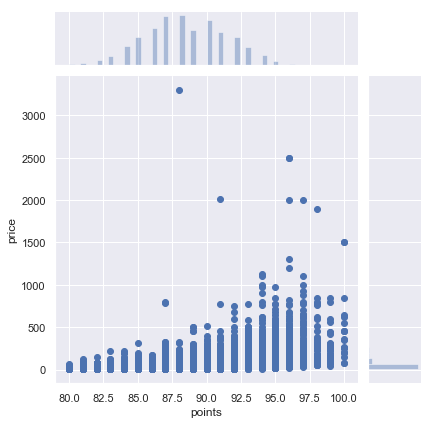

In [8]:
sns.jointplot(x="points", y="price", data=df, )

Box plot of the points feature. Scores range from 80 to 100.

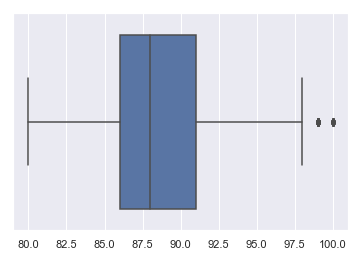

In [9]:
sns.boxplot(x=["points"], data=df)

We plot the same thing for the price feature. This time, for readability, we have to use a log scale. Where the wine score is bounded and has very few outliers, the price feature has an important range, numerous outliers with wines wort thousands of euros.

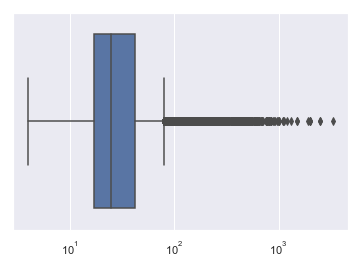

In [10]:
priceBoxPlot = sns.boxplot(x=["price"], data=df)
priceBoxPlot.figure.get_axes()[0].set_xscale('log')

Now, let's take a look at the correlation between price and score. We can expect it to be highly correlated as expensive wine should be better. Of course, the first scatter plot tends to show that it's not that obvious already.

In [11]:
np.corrcoef(df["price"], df["points"])

array([[1.        , 0.41616674],
       [0.41616674, 1.        ]])

The correlation between price and score is positive, albeit weaker than expected.

# Text mining: can we predict the score of a wine based on the review ?

First, let's put our text reviews in the corpus variable, and the variable we want to predict, the wine's score in Y. Then, we discretize the wine's score into 4 categories to make it a classification problem.

In [18]:
corpus = df["description"].values
Y = df["points"].values

#Discretization
Y[Y<85]=0
Y[np.logical_and(Y>3, Y<90)]=1
Y[np.logical_and(Y>3, Y<95)]=2
Y[np.logical_and(Y>3, Y<=100)]=3

#Re-type Y as int
Y=Y.astype(int)

array([1, 1, 1, ..., 2, 2, 2])

### Bag of Words using CountVectorizer

In [13]:
#Customize stop words after having a first look at the most frequent words
customStopWords = text.ENGLISH_STOP_WORDS.union(['wine', '2015','2016', '2017', '2018', '2019', '2020', '100', '10', '20'])

CV = CountVectorizer(stop_words=customStopWords, max_features=400)

X = CV.fit_transform(corpus) #Let's be careful here, X is a sparse Matrix

#CV.vocabulary_ #This show the 400 most frequent words selected (excluding stop_words)

### TFIDF (Term Frequency–Inverse Document Frequency)

In [14]:
TFIDF = TfidfTransformer()
X_TFIDF = TFIDF.fit_transform(X)

### Truncated SVD: an attempt at dimension reduction

In [15]:
n_components = 399

Y_rep = [0] #Will stock the cumulative explained variance ratio of the SVD, for each n_components

#Actual SVD
SVD = TruncatedSVD(n_components = n_components) 
X_SVD = SVD.fit_transform(X_TFIDF)
var = SVD.explained_variance_ratio_

#This will help us decide on the final number of components we want to keep 
for x in range(n_components): 
    clear_output(wait=True)
    
    Y_rep.append(Y_rep[-1]+var[x])
    
    print("Current progress: {0:.2f}%".format(x/(n_components-1)*100))
    


Current progress: 100.00%


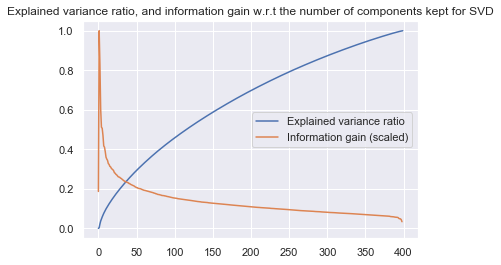

In [16]:
plt.plot(Y_rep)
plt.plot(var*54)

plt.title("Explained variance ratio, and information gain w.r.t the number of components kept for SVD")
plt.legend(['Explained variance ratio', 'Information gain (scaled)'], loc='best')

plt.show()

In order to reduce the number of features, we can use Truncated SVD to form linear combination of features minimizing the loss of information. Although here, even if we try to keep 200 features, we would loose more than 30% of the information.

It indicates that the words we kept in the CountVectorizer can not be gathered to form more abstract concepts without losing a lot of information. Truncated SVD might not be a good option here, we will try to use classifiers on X_TFIDF. We'll come back to truncated SVD if the calculations are too long.

### A first simple approach

In [21]:
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.naive_bayes import MultinomialNB
#from sklearn.linear_model import PassiveAggressiveClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import auc, cohen_kappa_score, confusion_matrix, roc_curve, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_TFIDF, Y,test_size=0.3, shuffle=True, random_state=95)

#FIRST TRY WITHOUT SVD 
knn = KNeighborsClassifier(n_neighbors=10)
print("Fitting...")
%time knn.fit(X_train, y_train)
print("\nPredicting...")
%time y_predicted = knn.predict(X_test)
print("\nReporting...\n")
print(classification_report(y_test, y_predicted),"\n")
print(confusion_matrix(y_test, y_predicted),"\n")
print("Cohen's Kappa score : ",cohen_kappa_score(y_test, y_predicted),"\n")




Fitting...
Wall time: 16 ms

Predicting...
Wall time: 2min 58s

Reporting...

              precision    recall  f1-score   support

           0       0.51      0.32      0.40      3605
           1       0.57      0.92      0.71     19075
           2       0.75      0.21      0.32     12953
           3       0.50      0.01      0.01       660

   micro avg       0.59      0.59      0.59     36293
   macro avg       0.58      0.36      0.36     36293
weighted avg       0.63      0.59      0.53     36293
 

[[ 1163  2414    28     0]
 [  950 17465   660     0]
 [  158 10120  2671     4]
 [    2   437   217     4]] 

Cohen's Kappa score :  0.20241102621928575 



In [24]:
rf = RandomForestClassifier(n_estimators = 500, bootstrap= True, n_jobs=-1)
print("Fitting...")
%time rf.fit(X_train, y_train)
print("\nPredicting...")
%time y_predicted = rf.predict(X_test)
print("\nReporting...\n")
print(classification_report(y_test, y_predicted),"\n")
print(confusion_matrix(y_test, y_predicted),"\n")
print("Cohen's Kappa score : ",cohen_kappa_score(y_test, y_predicted),"\n")

Fitting...
Wall time: 4min 40s

Predicting...
Wall time: 1.91 s

Reporting...

              precision    recall  f1-score   support

           0       0.77      0.30      0.43      3605
           1       0.71      0.87      0.78     19075
           2       0.75      0.66      0.71     12953
           3       1.00      0.01      0.02       660

   micro avg       0.72      0.72      0.72     36293
   macro avg       0.81      0.46      0.48     36293
weighted avg       0.73      0.72      0.70     36293
 

[[ 1088  2483    34     0]
 [  322 16538  2215     0]
 [    9  4345  8599     0]
 [    0    75   578     7]] 

Cohen's Kappa score :  0.49067957625464464 



In [26]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=20, max)
print("Fitting...")
%time dt.fit(X_train, y_train)
print("\nPredicting...")
%time y_predicted = dt.predict(X_test)
print("\nReporting...\n")
print(classification_report(y_test, y_predicted),"\n")
print(confusion_matrix(y_test, y_predicted),"\n")
print("Cohen's Kappa score : ",cohen_kappa_score(y_test, y_predicted),"\n")

Fitting...
Wall time: 14 s

Predicting...
Wall time: 20 ms

Reporting...

              precision    recall  f1-score   support

           0       0.60      0.20      0.30      3605
           1       0.63      0.80      0.71     19075
           2       0.63      0.53      0.58     12953
           3       0.17      0.03      0.04       660

   micro avg       0.63      0.63      0.63     36293
   macro avg       0.51      0.39      0.41     36293
weighted avg       0.62      0.63      0.61     36293
 

[[  708  2750   147     0]
 [  420 15255  3381    19]
 [   51  5927  6910    65]
 [    2   165   476    17]] 

Cohen's Kappa score :  0.31664953513246097 



In [30]:
nb = MultinomialNB()
print("Fitting...")
%time nb.fit(X_train, y_train)
print("\nPredicting...")
%time y_predicted = nb.predict(X_test)
print("\nReporting...\n")
print(classification_report(y_test, y_predicted),"\n")
print(confusion_matrix(y_test, y_predicted),"\n")
print("Cohen's Kappa score : ",cohen_kappa_score(y_test, y_predicted),"\n")

Fitting...
Wall time: 30 ms

Predicting...
Wall time: 7 ms

Reporting...

              precision    recall  f1-score   support

           0       0.79      0.04      0.08      3605
           1       0.63      0.87      0.73     19075
           2       0.69      0.52      0.59     12953
           3       0.00      0.00      0.00       660

   micro avg       0.65      0.65      0.65     36293
   macro avg       0.53      0.36      0.35     36293
weighted avg       0.66      0.65      0.60     36293
 

[[  152  3367    86     0]
 [   39 16650  2386     0]
 [    2  6226  6725     0]
 [    0   129   531     0]] 

Cohen's Kappa score :  0.32601989079960325 



In [31]:
pa = PassiveAggressiveClassifier(max_iter=1000, n_jobs=-1)
print("Fitting...")
%time pa.fit(X_train, y_train)
print("\nPredicting...")
%time y_predicted = pa.predict(X_test)
print("\nReporting...\n")
print(classification_report(y_test, y_predicted),"\n")
print(confusion_matrix(y_test, y_predicted),"\n")
print("Cohen's Kappa score : ",cohen_kappa_score(y_test, y_predicted),"\n")

Fitting...
Wall time: 18.6 s

Predicting...
Wall time: 8.04 ms

Reporting...

              precision    recall  f1-score   support

           0       0.53      0.31      0.39      3605
           1       0.66      0.77      0.71     19075
           2       0.65      0.60      0.62     12953
           3       0.05      0.00      0.01       660

   micro avg       0.65      0.65      0.65     36293
   macro avg       0.47      0.42      0.43     36293
weighted avg       0.63      0.65      0.64     36293
 

[[ 1121  2370   111     3]
 [  890 14691  3469    25]
 [   97  5073  7750    33]
 [    1    84   572     3]] 

Cohen's Kappa score :  0.36856002856836245 



To do : 
- try XGBOOST
- random forest parameters tuning with gridsearch
- adaboosting on random forest
- try to train on a more balanced subset of the data (not enough class1 and class4)
- use 10 fold to evaluate models
- make nicer confusion matrix
- refactor